# Grid path planning with dynamics

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/grid_states.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This example uses a uniform grid for its roadmap, but extended over higher dimensions to include velocity states.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Start by defining a set of position values

In [2]:
pos_step = 1.0
x_range = np.arange(0,10,pos_step)
y_range = np.arange(0,10,pos_step)

In this example, I'm going to use a slightly odd-shaped grid with velocities in a ring, respecting minimum and maximum speed limits.  Define the speed points first.

In [3]:
vmin = 1.0
vmax = 1.2
spd_range = np.linspace(vmin,vmax,4)
print(spd_range)

[1.         1.06666667 1.13333333 1.2       ]


Now a range of possible heading angles.

In [4]:
num_angles = 8
hdg_range = np.arange(0,2*np.pi,2*np.pi/num_angles)
print(hdg_range)

[0.         0.78539816 1.57079633 2.35619449 3.14159265 3.92699082
 4.71238898 5.49778714]


For later, define a turn radius limit, and use that to derive an ecceleration upper limit.

In [5]:
turn_radius = 0.5
acc_limit = vmin**2/turn_radius
print(acc_limit)

2.0


Now let's form the grid and inspect it.

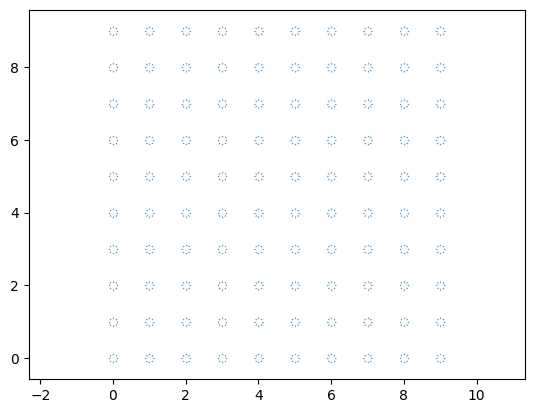

In [6]:
grid_points = [(x,y,spd*np.cos(theta),spd*np.sin(theta)) for x in x_range for y in y_range for theta in hdg_range for spd in spd_range]
vel_scale = 0.1
plt.plot([p[0]+vel_scale*p[2] for p in grid_points],[p[1]+vel_scale*p[3] for p in grid_points],'+',markersize=0.1)
plt.axis('equal')
plt.savefig('grid.pdf',dpi=1200)
plt.show()

Now, to represent an obstacle in the environment, some grid points will be removed.  You can select which to remove by any method, so this algorithm is very flexible about how obstacles are represented.  FOr simplicity, this example just assumes a circular obstacle centred on (4,3) and removes any points that are too close.

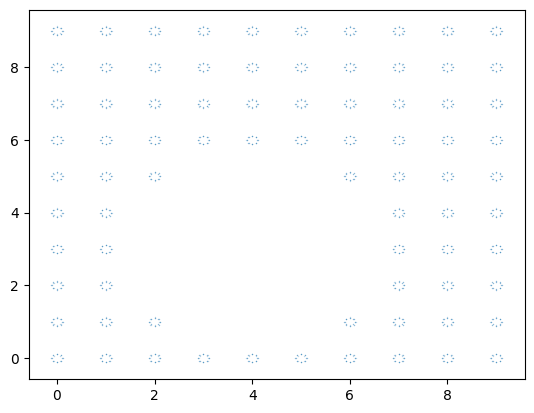

In [7]:
grid_points = [p for p in grid_points if (p[0]-4)**2 + (p[1]-3)**2 > 5]
plt.plot([p[0]+vel_scale*p[2] for p in grid_points],[p[1]+vel_scale*p[3] for p in grid_points],'+',markersize=0.1)
plt.show()

See how big this grid is...

In [8]:
num_points = len(grid_points)
print(num_points)

2528


## Connecting grid points

To determine which grid points are connected and the cost of traveling between them, we will fit cubic _splines_ between pairs of states.  First some utility functions for cubics.

### Fitting and drawing cubic splines

The code below does some simple maths to find the curve $p = a + bs +cs^2 + ds^3$ over the interval $s \in [0,1]$ that satisfies some boundary conditions:
- $p(0) = p_0$
- $p(1) = p_1$
- $\frac{dp}{ds}(0) = v_0$
- $\frac{dp}{ds}(1) = v_1$

Then there's a utility function for plotting the curve and its derivatives, and a simple test example.

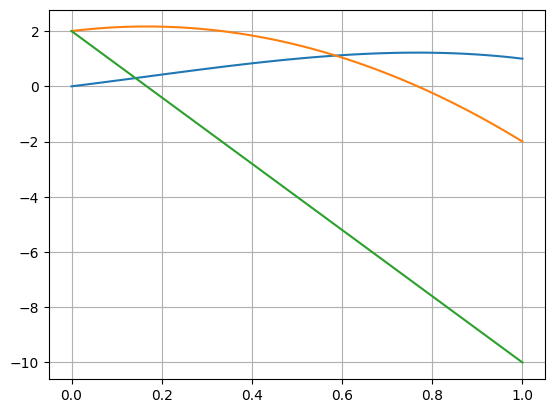

In [9]:
def fit_cubic(p0,p1,v0,v1):
    a = p0
    b = v0
    c = 3*(p1-p0) - v1 - 2*v0
    d = v1 + v0 - 2*(p1-p0)
    return a,b,c,d

def eval_cubic(a,b,c,d,s,deriv = 0):
    if deriv==0:
        return a + b*s + c*(s**2) + d*(s**3)
    elif deriv==1:
        return b + 2*c*s + 3*d*s**2
    elif deriv==2:
        return 2*c + 6*d*s
    else:
        raise(NotImplemented())

p0 = 0
v0 = 2
p1 = 1
v1 = -2

a,b,c,d = fit_cubic(p0,p1,v0,v1)

s = np.linspace(0,1,50)
p = eval_cubic(a,b,c,d,s)
v = eval_cubic(a,b,c,d,s,deriv=1)
a = eval_cubic(a,b,c,d,s,deriv=2)
plt.plot(s,p,s,v,s,a)
plt.grid('on')
plt.show()

Now we deploy this for joining two example grid points, scaling by a timestep $T$.

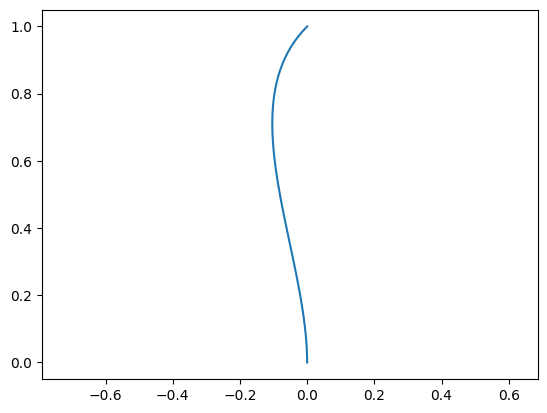

In [10]:
x1,y1,vx1,vy1 = 0,0,0,1
x2,y2,vx2,vy2 = 0,1,0.7,0.7

T = 1.0

ax,bx,cx,dx = fit_cubic(x1,x2,T*vx1,T*vx2)
ay,by,cy,dy = fit_cubic(y1,y2,T*vy1,T*vy2)

x = eval_cubic(ax,bx,cx,dx,s)
y = eval_cubic(ay,by,cy,dy,s)

plt.plot(x,y)
plt.axis('equal')
plt.show()

Looking at the acceleration values, including both components and their joint magnitude, confirms that the values are greatest at the endpoints.

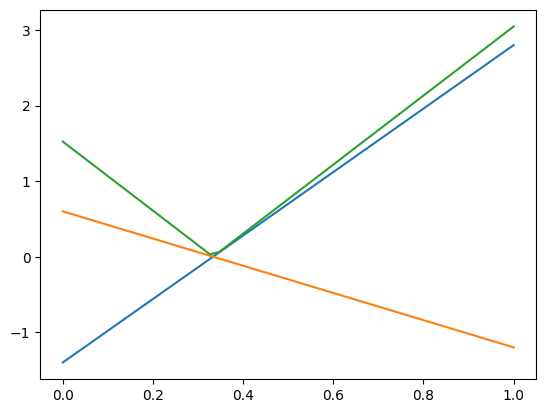

In [11]:
accx = eval_cubic(ax,bx,cx,dx,s,deriv=2)/T**2
accy = eval_cubic(ay,by,cy,dy,s,deriv=2)/T**2
accm = np.sqrt(accx**2 + accy**2)
plt.plot(s,accx,s,accy,s,accm)
plt.show()

### Finding trajectories between neighbouring grid points

Now to combine all of this into a function that tries to connect two gridpoints.

In [12]:
def are_neighbours(s1,s2):
    if np.abs(s1[0]-s2[0])>pos_step:
        return False
    if np.abs(s1[1]-s2[1])>pos_step:
        return False
    return True

default_time_step = pos_step*2/(vmax+vmin)
print(default_time_step)
max_step_time = 1.7*default_time_step

def travel_time(s1,s2):
    # don't connect points too far away - adjacent grid points only
    if not are_neighbours(s1,s2):
        return np.inf,[],[]
    x1,y1,vx1,vy1 = s1
    x2,y2,vx2,vy2 = s2
    # can't connect to own location - no turning on the spot
    if x1==x2 and y1==y2:
        return np.inf,[],[]
    # assume the default time step length, then increase time step if acceleration too high
    T = default_time_step
    for ii in range(10):
        ax,bx,cx,dx = fit_cubic(x1,x2,T*vx1,T*vx2)
        ay,by,cy,dy = fit_cubic(y1,y2,T*vy1,T*vy2)
        acc0 = np.sqrt((2*cx)**2 + (2*cy)**2)/T**2
        acc1 = np.sqrt((2*cx + 6*dx)**2 + (2*cy + 6*dy)**2)/T**2
        acc_max = max(acc0,acc1)
        if acc_max > acc_limit:
            T = T*2
        else:
            break
    # if we had to turn up the time step, refine it with bisection search
    if T>default_time_step:
        T_high = T
        T_low = T/2
        for ii in range(6):
            T = 0.5*(T_high+T_low)
            ax,bx,cx,dx = fit_cubic(x1,x2,T*vx1,T*vx2)
            ay,by,cy,dy = fit_cubic(y1,y2,T*vy1,T*vy2)
            acc0 = np.sqrt((2*cx)**2 + (2*cy)**2)/T**2
            acc1 = np.sqrt((2*cx + 6*dx)**2 + (2*cy + 6*dy)**2)/T**2
            acc_max = max(acc0,acc1)
            if acc_max > acc_limit:
                T_low = T
            else:
                T_high = T
    # don't connect if transition time too long
    if T > max_step_time:
        return np.inf,[],[]
    # return the travel time and the trajectory
    s = np.linspace(0,1,20)
    x = eval_cubic(ax,bx,cx,dx,s)
    y = eval_cubic(ay,by,cy,dy,s)
    return T,x,y


0.9090909090909091


Try an example

1.1505681818181817


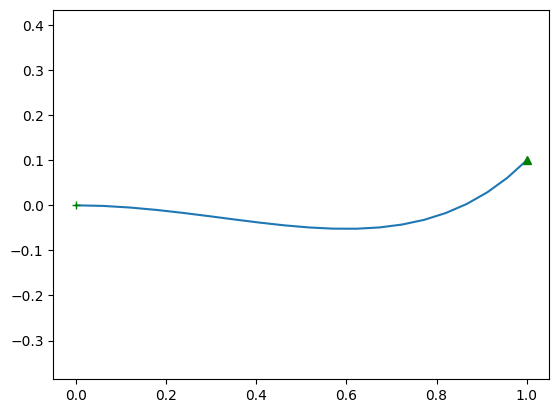

In [13]:
s1 = (0.0,0.0,1.0,0.0)
s2 = (1.0,0.1,0.7,0.7)
t,x,y = travel_time(s1,s2)
print(t)
plt.plot(x,y)
plt.plot(s1[0],s1[1],'g+')
plt.plot(s2[0],s2[1],'g^')
plt.axis('equal')
plt.show()

Now try all the connections from a single grid position.  Pretty!

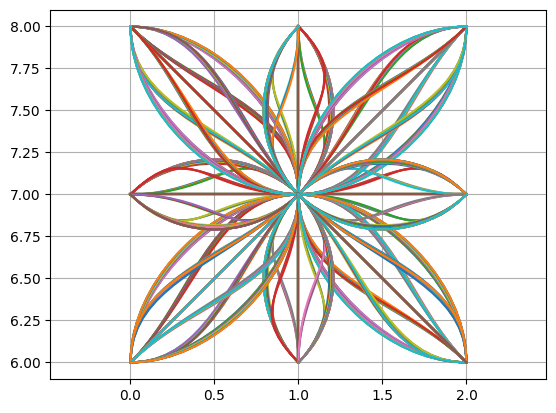

In [14]:
for (i1,s1) in enumerate(grid_points):
    if (s1[0],s1[1])!=(1.0,7.0):
        continue
    for (i2,s2) in enumerate(grid_points):
        t12,x,y = travel_time(s1,s2)
        if t12 < np.inf:
            plt.plot(x,y,'-')
plt.axis('equal')
plt.grid('on')
plt.show()

Doing this for all possible grid point pairs is going to be slow, and many of the jobs will be the same, just shifted in position.  Define a helper function that looks up similar trajectories in a cache to save effort recalculating.

In [15]:
link_cache = {}

def travel_time_using_cache(s1,s2):
    if not are_neighbours(s1,s2):
        return np.inf,[],[]
    x1,y1,vx1,vy1 = s1
    x2,y2,vx2,vy2 = s2
    dx = x2-x1
    dy = y2-y1
    cache_key = (dx,dy,vx1,vy1,vx2,vy2)
    if cache_key in link_cache:
        t12,x,y = link_cache[cache_key]
    else:
        t12,x,y = travel_time((0,0,vx1,vy1),(dx,dy,vx2,vy2))
        link_cache[cache_key] = (t12,x,y)
    return t12,x+x1,y+y1

## Building the roadmap

Now calculate the cost and trajectories of all possible state transitions to build the distance matrix.  This is our roadmap.

In [16]:
cost_matrix = np.inf*np.ones((num_points,num_points))
link_matrix = {}
for (i1,s1) in enumerate(grid_points):
    for (i2,s2) in enumerate(grid_points):
        #t12,x,y = travel_time(s1,s2)
        t12,x,y = travel_time_using_cache(s1,s2)
        cost_matrix[i1,i2] = t12
        if t12<np.inf:
            link_matrix[(i1,i2)] = (x,y)

Check whether or not the cache was any help - should see a significantly smaller cache than the total number of pairs tested.

In [17]:
print(len(link_cache))
print(len(grid_points)**2)

9216
6390784


Now run graph search on this map to find all the shortest paths between traversible node pairs.

In [18]:
from scipy.sparse.csgraph import shortest_path
path_length,predecessors = shortest_path(cost_matrix, return_predecessors=True)

## Querying the roadmap

Choose two points and check they are connected, _i.e._ that the path length between them is finite.

In [19]:
print(num_points)
start_node = 120
target_node = 1729
print(grid_points[start_node])
print(grid_points[target_node])
print(path_length[start_node,target_node])

2528
(0.0, 3.0, -1.8369701987210297e-16, -1.0)
(7.0, 5.0, 1.0666666666666667, 0.0)
10.681818181818183


Now use the `predecessors` matrix to track backwards from target node to starting node and plot the path.

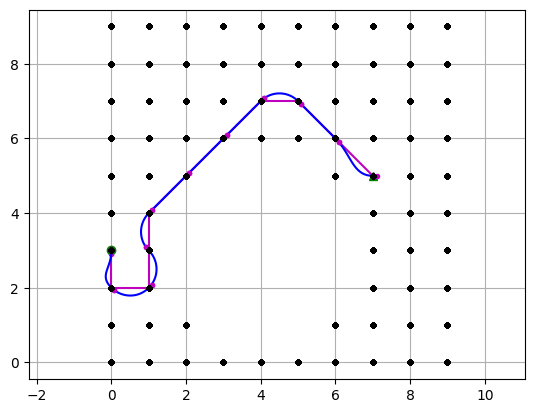

In [20]:
plt.plot([grid_points[start_node][0]],
         [grid_points[start_node][1]],'go')
plt.plot([grid_points[target_node][0]],
         [grid_points[target_node][1]],'g^')
curr_node = target_node
for kk in range(len(grid_points)):
    prev_node = predecessors[start_node,curr_node]
    plt.plot([grid_points[curr_node][0] + vel_scale*grid_points[curr_node][2],
              grid_points[prev_node][0] + vel_scale*grid_points[prev_node][2]],
             [grid_points[curr_node][1] + vel_scale*grid_points[curr_node][3],
              grid_points[prev_node][1] + vel_scale*grid_points[prev_node][3]],'m.')
    plt.plot([grid_points[curr_node][0],
              grid_points[prev_node][0]],
             [grid_points[curr_node][1],
              grid_points[prev_node][1]],'m-')
    px,py = link_matrix[(prev_node,curr_node)]
    plt.plot(px,py,'b-')
    curr_node=prev_node
    if curr_node==start_node:
        break
plt.plot([p[0] for p in grid_points],[p[1] for p in grid_points],'k.')
plt.grid('on')
plt.axis('equal')
plt.show()